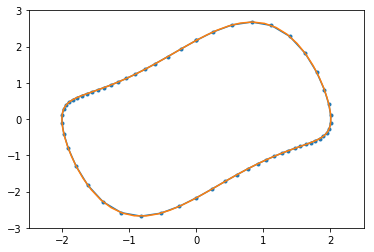

In [2]:
import math
import numpy as np
import matplotlib.pyplot as plt

from pydrake.examples.van_der_pol import (VanDerPolOscillator)
from pydrake.all import (DirectCollocation, PiecewisePolynomial,
                         SolutionResult)

plant = VanDerPolOscillator()
context = plant.CreateDefaultContext()

dircol = DirectCollocation(plant, context, num_time_samples=61,
                           minimum_timestep=0.01, maximum_timestep=0.5)

dircol.AddEqualTimeIntervalsConstraints()

# Initial state on the surface of section (and velocity > .1).
dircol.AddBoundingBoxConstraint([0., 0.1], [0., 10.], dircol.initial_state())

# Periodicity constraint.
# TODO(russt): Replace this with the vectorized version pending drake #8315.
dircol.AddLinearConstraint(
    dircol.final_state()[0] == dircol.initial_state()[0])
dircol.AddLinearConstraint(
    dircol.final_state()[1] == dircol.initial_state()[1])

samples = np.linspace(0, 2*math.pi, 10)
x_guess = np.vstack(([2*math.sin(t) for t in samples],
                     [2*math.cos(t) for t in samples]))
initial_x_trajectory = PiecewisePolynomial.FirstOrderHold(samples, x_guess)

dircol.SetInitialTrajectory(PiecewisePolynomial(), initial_x_trajectory)

fig = plt.figure()
h, = plt.plot([], [], '.-')
plt.xlim((-2.5, 2.5))
plt.ylim((-3., 3.))


def draw_trajectory(t, x):
    h.set_xdata(x[0, :])
    h.set_ydata(x[1, :])
    fig.canvas.draw()
    if plt.get_backend() == u'MacOSX':
        plt.pause(1e-10)


dircol.AddStateTrajectoryCallback(draw_trajectory)

result = dircol.Solve()
assert(result == SolutionResult.kSolutionFound)

x_trajectory = dircol.ReconstructStateTrajectory()

x_knots = np.hstack([x_trajectory.value(t) for t in
                     np.linspace(x_trajectory.start_time(),
                                 x_trajectory.end_time(), 100)])
plt.plot(x_knots[0, :], x_knots[1, :])

#plt.show()
